# Generating the graph for 5 submissions

This notebook contains code from the 'Phase1_Network_Graph.ipynb' notebook, but it considers only five submissions and generates the graphs.

# **the code is up to date**

---
Reading the data
---


.

In [ ]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cpu.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
data_subreddit_t5_22i0 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/reddit_project/data_subreddit_t5_22i0.csv')
print(len(data_subreddit_t5_22i0)) #length of data = 6142
print(len(pd.unique(data_subreddit_t5_22i0['subreddit_id']))) #number of subreddits considered = 1
print(len(pd.unique(data_subreddit_t5_22i0['id']))) #unique number of comments =  6142, the data is at the comment level
print(len(pd.unique(data_subreddit_t5_22i0['parent_id']))) #number of parent nodes = 3501
print(len(pd.unique(data_subreddit_t5_22i0['link_id']))) #number of submissions = 253

6142
1
6142
3501
253


In [ ]:
data_subreddit_t5_22i0 = data_subreddit_t5_22i0[data_subreddit_t5_22i0['link_id'].isin(['t3_5lbzj0', 't3_5lca7i', 't3_5lbr04', 't3_5lcd9r' ,'t3_5lcet3'])]
print(len(data_subreddit_t5_22i0)) #length of data = 388
print(len(pd.unique(data_subreddit_t5_22i0['subreddit_id']))) #number of subreddits considered = 1
print(len(pd.unique(data_subreddit_t5_22i0['id']))) #unique number of comments = 388, the data is at the comment level
print(len(pd.unique(data_subreddit_t5_22i0['parent_id']))) #number of parent nodes = 186
print(len(pd.unique(data_subreddit_t5_22i0['link_id']))) #number of submissions = 5
print(len(pd.unique(data_subreddit_t5_22i0['author'])))

330
1
330
186
5
163


In [ ]:
print(data_subreddit_t5_22i0['link_id'].unique())

['t3_5lca7i' 't3_5lbr04' 't3_5lcd9r' 't3_5lcet3' 't3_5lbzj0']


In [ ]:
data_subreddit_t5_22i0.head(3)

,Unnamed: 0,edited,id,parent_id,distinguished,created_utc,author_flair_text,author_flair_css_class,controversiality,subreddit_id,retrieved_on,link_id,author,score,gilded,stickied,body,subreddit
1,117,0,dbumnt9,t1_dbumgyw,NaN,1483228803,Hamburg,HAMB,0,t5_22i0,1485679712,t3_5lca7i,TikeRike,4,0,False,Glückwunsch zum Geburtstag!,de
2,338,0,dbumnzf,t1_dbul14e,NaN,1483228811,Freiburg,FREIBU,0,t5_22i0,1485679714,t3_5lbr04,oldandgreat,1,0,False,"Dieser Sesamstraßen Frosch war hip auf Bpt, do...",de
3,454,1483229620,dbumo2p,t1_dbulyr6,NaN,1483228815,NaN,NaN,0,t5_22i0,1485679715,t3_5lcd9r,arteoncc,60,0,False,"Racial Profiling, erstmal paar Stunden festhal...",de


---
Generate Graph for 5 submissions using Method 2a
---


.

In [ ]:
data_method2a = pd.DataFrame(columns=['subreddit_id','submission_id','from_user','to_user','edgeweight_method2a'])
print(data_method2a)

Empty DataFrame
Columns: [subreddit_id, submission_id, from_user, to_user, edgeweight_method2a]
Index: []


In [ ]:
def method2a_function(subreddit_id, subreddit_data):
  data_method2a = pd.DataFrame(columns=['subreddit_id','submission_id','from_user','to_user','edgeweight_method2a'])
  #print(data_method2a)

  #obtain the link_id's of all submission in the subreddit
  submissions_list = subreddit_data['link_id'].unique()
  #obtain the names of all user's in the subreddit
  #author_list = subreddit_data['author'].unique()
  #print(author_list[0])
  #print(author_list[1])

  print("Consider subreddit with ID: ",subreddit_id)
  print("total number of submission: ",len(submissions_list))
  counter = 0
  ignore_comments_counter = 0

  #iterate across all submissions
  for i in submissions_list:
    print('\n***********************')
    counter += 1
    curr_link_id = i
    print("consider submission with link_id = "+str(curr_link_id)+ " ("+str(counter)+"/"+str(len(submissions_list))+")")

    #obtain all comments made on this submission from the subreddit
    submission_comments = subreddit_data.loc[subreddit_data['link_id'] == curr_link_id]
    #print(submission_comments.head(3))

    #obtain the names of all user's in the subsmission
    author_list = submission_comments['author'].unique()
    print("total number of authors: ",len(author_list))

    #number of comments on the subreddit
    tot_comments = len(submission_comments)
    print("total number of comments in this submission = ", tot_comments)
    j = 0

    #iterate across the current submission
    for index, row in submission_comments.iterrows():
      j += 1
      #print('comment '+str(j)+" ---------------")

      curr_author = row['author']
      curr_parent_comment_id = row['parent_id'][3:] #noticed that the parent id is nothing but the comment id preceded by 3 characters
      #print(curr_parent_comment_id)

      #identify if a comment is a primary comment
      primary_comment_flag = 0
      if row['parent_id'] == row['link_id']: #it is a primary comment
        #print("primary comment")
        primary_comment_flag = 1

      #rule out any comment that does not have a valid parent in the submission
      #(the parent id of a given comment should be either (i) the link id itslef for a primary comment
      # or
      # the id of another comment in the submission)
      if(len(submission_comments[submission_comments['id'] == curr_parent_comment_id]['author']) == 0): #the parent comment could not be found
        #print(primary_comment_flag)
        #if (primary_comment_flag == 1):
          #print('this comment is a reply to the submission and hence will not have an edge')
        #else:
          #print('this comment was made as a reply to another comment which cannot be found in the data')
        #print('there')
        ignore_comments_counter += 1
        continue

      primary_comment_flag = 0
      #print('Found a valid parent comment in the submission')
      curr_parent = submission_comments[submission_comments['id'] == curr_parent_comment_id]['author'].values[0]
      #print('The parent comment was made by author: '+str(curr_parent))
      curr_comment_id = row['id']

      all_replies_to_parent_df = submission_comments[(submission_comments["parent_id"] == row['parent_id'])]
      if len(all_replies_to_parent_df) == 0:
        #print('reached here 1')
        ignore_comments_counter += 1
        continue
      curr_author_all_replies_to_parent_df = all_replies_to_parent_df[(all_replies_to_parent_df["author"] == curr_author)]
      if len(curr_author_all_replies_to_parent_df) == 0:
        #print('reached here 2')
        ignore_comments_counter += 1
        continue
      else:
        #print("edge weight for this comment: "+str(len(curr_author_all_replies_to_parent_df))+"/"+str(len(all_replies_to_parent_df)))
        #weighted_interaction_between_curr_and_curr_parent = float("{:.2f}".format((len(curr_author_all_replies_to_parent_df)/len(all_replies_to_parent_df))))
        weighted_interaction_between_curr_and_curr_parent = ((len(curr_author_all_replies_to_parent_df)/len(all_replies_to_parent_df)))
        #add the row to the dataframe
        if len(data_method2a[(data_method2a['from_user'] == curr_author)&(data_method2a['to_user'] == curr_parent)&(data_method2a['submission_id'] == curr_link_id)].values) > 0: #there exists a row with the curr_aithor to curr_parent in the same submission already
          #print('here')
          ignore_comments_counter += 1
          continue
        else:
          data_method2a.loc[len(data_method2a.index)] = [subreddit_id, curr_link_id, curr_author, curr_parent, weighted_interaction_between_curr_and_curr_parent]
          #print('length of submission data frame: '+str(len(data_method2a)))

    #data_method2a.append(data_method2a_local,ignore_index=True)
    #print(data_method2a_local)
    #print('appended, new length of data frame: '+str(len(data_method2a)))
  print('total number of comments ignored: ' +str(ignore_comments_counter))
  return data_method2a

data_method2a = method2a_function('t5_22i0',data_subreddit_t5_22i0)


Consider subreddit with ID:  t5_22i0
total number of submission:  5

***********************
consider submission with link_id = t3_5lca7i (1/5)
total number of authors:  36
total number of comments in this submission =  38

***********************
consider submission with link_id = t3_5lbr04 (2/5)
total number of authors:  40
total number of comments in this submission =  67

***********************
consider submission with link_id = t3_5lcd9r (3/5)
total number of authors:  68
total number of comments in this submission =  136

***********************
consider submission with link_id = t3_5lcet3 (4/5)
total number of authors:  37
total number of comments in this submission =  77

***********************
consider submission with link_id = t3_5lbzj0 (5/5)
total number of authors:  9
total number of comments in this submission =  12
total number of comments ignored: 148


In [ ]:
print(len(data_method2a))
print(data_method2a.head(3))

182
  subreddit_id submission_id     from_user    to_user  edgeweight_method2a
0      t5_22i0     t3_5lca7i  Johanneskodo  swabianne                  1.0
1      t5_22i0     t3_5lca7i   epsenohyeah    Zarqu0n                  1.0
2      t5_22i0     t3_5lca7i    hexagon672  Veniabiit                  1.0


In [ ]:
data_method2a_final = pd.DataFrame(columns=['from_user','to_user','edgeweight_method2a'])
print(data_method2a_final)

Empty DataFrame
Columns: [from_user, to_user, edgeweight_method2a]
Index: []


In [ ]:
data_method2a_final = data_method2a.groupby(['from_user', 'to_user'], as_index=False)['edgeweight_method2a'].mean()

In [ ]:
print(len(data_method2a_final))
print(data_method2a_final.columns)
print(data_method2a_final.head(140))

180
Index(['from_user', 'to_user', 'edgeweight_method2a'], dtype='object')
             from_user            to_user  edgeweight_method2a
0             100limes               xjcl             1.000000
1    6A-F9-A1-CC-29-C0         Doldenberg             0.250000
2    6A-F9-A1-CC-29-C0       _AGermanGuy_             1.000000
3    6A-F9-A1-CC-29-C0           arteoncc             0.333333
4    6A-F9-A1-CC-29-C0       omfgwallhax2             0.250000
..                 ...                ...                  ...
135         hexagon672          Veniabiit             1.000000
136    humanlikecorvus       Fauler_Lentz             1.000000
137    humanlikecorvus         Rievkooche             1.000000
138       hypnoconsole  6A-F9-A1-CC-29-C0             0.500000
139       iphoneman321          [deleted]             0.500000

[140 rows x 3 columns]


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
G_method2a = nx.from_pandas_edgelist(data_method2a_final, "from_user", "to_user", edge_attr="edgeweight_method2a", create_using=nx.DiGraph()) #weight for graph not set

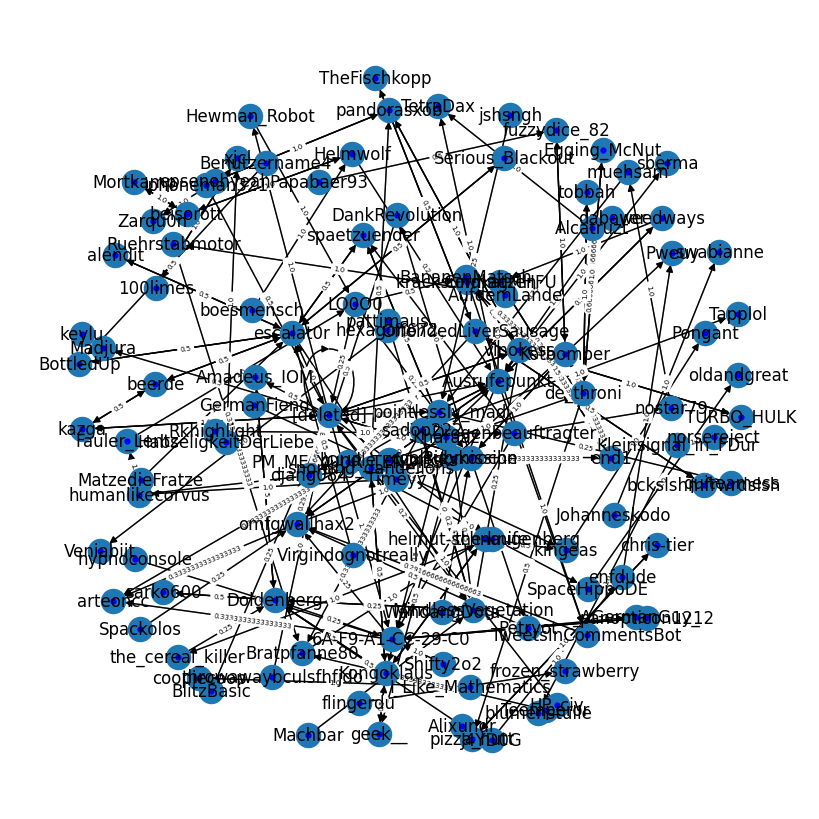

In [ ]:
from matplotlib.pyplot import text
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_method2a, k=0.61)  # For better example looking
d = dict(G_method2a.degree)
labels = {e: G_method2a.edges[e]['edgeweight_method2a'] for e in G_method2a.edges}
nx.draw(G_method2a, pos,with_labels=True)
nx.draw_networkx_edges(G_method2a, pos, alpha=0.4)
nx.draw_networkx_nodes(G_method2a, pos, node_size=12, node_color="b")
nx.draw_networkx_edge_labels(G_method2a, pos, edge_labels=labels, font_size = 5)
#nx.draw_networkx_labels(G_method2a, pos, labels=labels, font_size = 5)

plt.show()

In [ ]:
print(G_method2a.number_of_nodes())
print(G_method2a.number_of_edges()) #edges same as number of rows
print(np.mean([d for _, d in G_method2a.degree()])) #average degree of nodes
print(G_method2a.size(weight='edgeweight_method2a'))

116
178
3.0689655172413794
122.96000000000002


In [ ]:
pip install node2vec

In [ ]:
from node2vec import Node2Vec as n2v

In [ ]:

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb = n2v(G_method2a,dimensions=128)

mdl2 = g_emb.fit(
    vector_size = 128,
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

Computing transition probabilities:   0%|          | 0/116 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 72.36it/s]


In [ ]:
comment_id = 'Doldenberg'
for s in mdl2.wv.most_similar(comment_id, topn = 10):
    print(s)

('sarko600', 0.993065595626831)
('Amadeus_IOM', 0.992051899433136)
('MindlessVegetation', 0.99191814661026)
('pattimaus', 0.9808222651481628)
('the_cereal_killer', 0.9780126214027405)
('Alixundr', 0.9676055908203125)
('Machbar', 0.9660874605178833)
('Kongoklaus', 0.9309418201446533)
('geek__', 0.9089988470077515)
('sadop222', 0.8839722275733948)


---
Generate Graph for 5 submissions subreddit using Method 2b
---


.

In [ ]:
data_method2b = pd.DataFrame(columns=['subreddit_id','submission_id','from_user','to_user','num', 'denom'])
print(data_method2b)

Empty DataFrame
Columns: [subreddit_id, submission_id, from_user, to_user, num, denom]
Index: []


In [ ]:
def method2b_function(subreddit_id, subreddit_data):
  submissions_list = subreddit_data['link_id'].unique()

  print("Consider subreddit with ID: ",subreddit_id)
  print("total number of submission: ",len(submissions_list))
  counter = 0
  ignore_comments_counter = 0

  #number of comments on the subreddit
  tot_comments = len(subreddit_data)
  print("total number of comments in this submission = ", tot_comments)

  #iterate across the current submission
  for index, row in subreddit_data.iterrows():
      curr_link_id = row['link_id']
      curr_author = row['author']
      curr_parent_comment_id = row['parent_id'][3:] #noticed that the parent id is nothing but the comment id preceded by 3 characters

      if(len(subreddit_data[subreddit_data['id'] == curr_parent_comment_id]['author']) == 0): #the parent comment could not be found
        ignore_comments_counter += 1
        continue

      #print('Found a valid parent comment in the submission')
      curr_parent = subreddit_data[subreddit_data['id'] == curr_parent_comment_id]['author'].values[0]

      all_replies_to_parent_df = subreddit_data[(subreddit_data["parent_id"] == row['parent_id'])]
      if len(all_replies_to_parent_df) == 0:
        ignore_comments_counter += 1
        continue
      curr_author_all_replies_to_parent_df = all_replies_to_parent_df[(all_replies_to_parent_df["author"] == curr_author)]
      if len(curr_author_all_replies_to_parent_df) == 0:
        ignore_comments_counter += 1
        continue
      else:
        if len(data_method2b[(data_method2b['from_user'] == curr_author)&(data_method2b['to_user'] == curr_parent)].values) > 0: #there exists a row with the curr_author to curr_parent in the same submission already
          ignore_comments_counter += 1
          continue
        else:
          data_method2b.loc[len(data_method2b.index)] = [subreddit_id, curr_link_id, curr_author, curr_parent,len(curr_author_all_replies_to_parent_df), len(all_replies_to_parent_df) ]

  print('total number of comments ignored: ' +str(ignore_comments_counter))
  return data_method2b

data_method2b = method2b_function('t5_22i0',data_subreddit_t5_22i0)


Consider subreddit with ID:  t5_22i0
total number of submission:  5
total number of comments in this submission =  330
total number of comments ignored: 150


In [ ]:
print(len(data_method2b))
print(data_method2b)

180
    subreddit_id submission_id            from_user          to_user  num  \
0        t5_22i0     t3_5lbr04         SpaceHippoDE      oldandgreat    1   
1        t5_22i0     t3_5lcd9r   PM_ME_YOUR_TENDIES     SpaceHippoDE    1   
2        t5_22i0     t3_5lcd9r         omfgwallhax2         arteoncc    1   
3        t5_22i0     t3_5lcd9r  TweetsInCommentsBot     omfgwallhax2    1   
4        t5_22i0     t3_5lca7i         Johanneskodo        swabianne    1   
..           ...           ...                  ...              ...  ...   
175      t5_22i0     t3_5lbzj0                keylu          Madjura    1   
176      t5_22i0     t3_5lbr04                 xjcl         100limes    1   
177      t5_22i0     t3_5lcd9r               Timeyy     Ausrufepunkt    1   
178      t5_22i0     t3_5lcet3               Timeyy  humanlikecorvus    1   
179      t5_22i0     t3_5lcet3               Timeyy       Rievkooche    1   

     denom  
0        1  
1        1  
2        3  
3        3  
4     

In [ ]:
data_method2b_final = pd.DataFrame(columns=['from_user','to_user','numerator','denominator'])
print(data_method2b_final)

Empty DataFrame
Columns: [from_user, to_user, numerator, denominator]
Index: []


In [ ]:
#data_method2b_final = data_method2b.groupby(['from_user', 'to_user'], as_index=False)['edgeweight_method2b'].mean()
data_method2b_final = data_method2b.groupby(['from_user', 'to_user'], as_index=False).agg({'num':'sum','denom':'sum'})

In [ ]:
print(len(data_method2b_final))
print(data_method2b_final.columns)
print(data_method2b_final.head(140))

180
Index(['from_user', 'to_user', 'num', 'denom'], dtype='object')
             from_user            to_user  num  denom
0             100limes               xjcl    1      1
1    6A-F9-A1-CC-29-C0         Doldenberg    1      4
2    6A-F9-A1-CC-29-C0       _AGermanGuy_    1      1
3    6A-F9-A1-CC-29-C0           arteoncc    1      3
4    6A-F9-A1-CC-29-C0       omfgwallhax2    1      4
..                 ...                ...  ...    ...
135         hexagon672          Veniabiit    1      1
136    humanlikecorvus       Fauler_Lentz    1      1
137    humanlikecorvus         Rievkooche    1      1
138       hypnoconsole  6A-F9-A1-CC-29-C0    1      2
139       iphoneman321          [deleted]    1      2

[140 rows x 4 columns]


create the new column which is the division of the numertaor/denominator

In [ ]:
data_method2b_final['edgeweight_method2b'] = data_method2b_final['num']/data_method2b_final['denom']

In [ ]:
print(len(data_method2b_final))
print(data_method2b_final.columns)
print(data_method2b_final.head(140))

180
Index(['from_user', 'to_user', 'num', 'denom', 'edgeweight_method2b'], dtype='object')
             from_user            to_user  num  denom  edgeweight_method2b
0             100limes               xjcl    1      1             1.000000
1    6A-F9-A1-CC-29-C0         Doldenberg    1      4             0.250000
2    6A-F9-A1-CC-29-C0       _AGermanGuy_    1      1             1.000000
3    6A-F9-A1-CC-29-C0           arteoncc    1      3             0.333333
4    6A-F9-A1-CC-29-C0       omfgwallhax2    1      4             0.250000
..                 ...                ...  ...    ...                  ...
135         hexagon672          Veniabiit    1      1             1.000000
136    humanlikecorvus       Fauler_Lentz    1      1             1.000000
137    humanlikecorvus         Rievkooche    1      1             1.000000
138       hypnoconsole  6A-F9-A1-CC-29-C0    1      2             0.500000
139       iphoneman321          [deleted]    1      2             0.500000

[140 row

In [ ]:
data_method2b_final.head()

,from_user,to_user,num,denom,edgeweight_method2b
0,100limes,xjcl,1,1,1.000000
1,6A-F9-A1-CC-29-C0,Doldenberg,1,4,0.250000
2,6A-F9-A1-CC-29-C0,_AGermanGuy_,1,1,1.000000
3,6A-F9-A1-CC-29-C0,arteoncc,1,3,0.333333
4,6A-F9-A1-CC-29-C0,omfgwallhax2,1,4,0.250000


In [ ]:
data_method2a_final.head()

,from_user,to_user,edgeweight_method2a
0,100limes,xjcl,1.000000
1,6A-F9-A1-CC-29-C0,Doldenberg,0.250000
2,6A-F9-A1-CC-29-C0,_AGermanGuy_,1.000000
3,6A-F9-A1-CC-29-C0,arteoncc,0.333333
4,6A-F9-A1-CC-29-C0,omfgwallhax2,0.250000


In [ ]:
G_method2b = nx.from_pandas_edgelist(data_method2b_final, "from_user", "to_user", edge_attr="edgeweight_method2b", create_using=nx.DiGraph()) #weight for graph not set

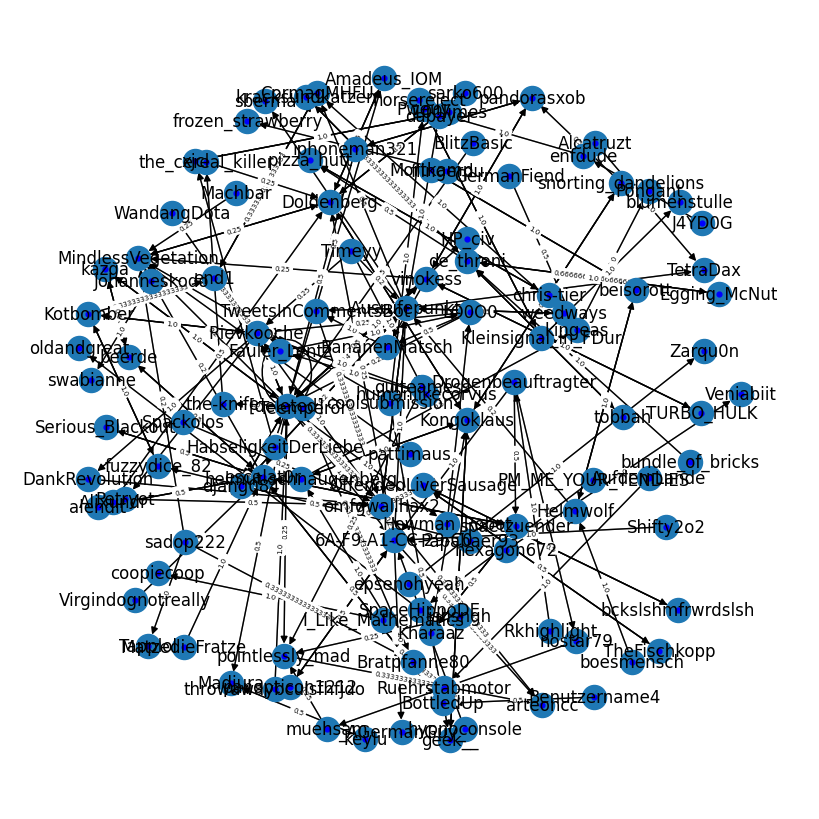

In [ ]:
from matplotlib.pyplot import text
plt.figure(figsize=(8, 8))
pos1 = nx.spring_layout(G_method2b, k=0.61)  # For better example looking
d1 = dict(G_method2b.degree)
labels1 = {e: G_method2b.edges[e]['edgeweight_method2b'] for e in G_method2b.edges}
nx.draw(G_method2b, pos1,with_labels=True)
nx.draw_networkx_edges(G_method2b, pos1, alpha=0.4)
nx.draw_networkx_nodes(G_method2b, pos1, node_size=12, node_color="b")
nx.draw_networkx_edge_labels(G_method2b, pos1, edge_labels=labels1, font_size = 5)
#nx.draw_networkx_labels(G_method2a, pos, labels=labels, font_size = 5)
plt.show()

In [ ]:
print(G_method2b.number_of_nodes()) #no.of nodes
print(G_method2b.number_of_edges()) #edges same as number of rows
print(np.mean([d for _, d in G_method2b.degree()])) #average degree of nodes
print(G_method2b.size(weight='edgeweight_method2b'))

116
178
3.0689655172413794
124.15198412698412


In [ ]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb2b = n2v(G_method2b,dimensions=128)

mdl2b = g_emb2b.fit(
    vector_size = 128,
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

Computing transition probabilities:   0%|          | 0/116 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 61.94it/s]


In [ ]:
comment_id = 'Doldenberg'
for s in mdl2b.wv.most_similar(comment_id, topn = 10):
    print(s)

('sarko600', 0.9945454597473145)
('Amadeus_IOM', 0.9942863583564758)
('MindlessVegetation', 0.9844993352890015)
('the_cereal_killer', 0.9763768315315247)
('Alixundr', 0.9725983738899231)
('Machbar', 0.96795654296875)
('pattimaus', 0.9647200703620911)
('Kongoklaus', 0.9320055246353149)
('geek__', 0.9141103625297546)
('snorting_dandelions', 0.8869923949241638)


---
check if both the graphs from method 2a and 2b are identical
---

.

In [ ]:
import networkx.algorithms.isomorphism as iso

In [ ]:
nx.is_isomorphic(G_method2a, G_method2b)

True

In [ ]:
em = iso.categorical_edge_match('edgeweight_method2a', 'edgeweight_method2b')
nx.is_isomorphic(G_method2a, G_method2b, edge_match=em)

False

In [ ]:
nx.is_isomorphic(G_method2a, G_method2b, edge_match=lambda x, y: x==y)

False

In [ ]:
data_method2a_final.equals(data_method2b_final[['from_user','to_user','edgeweight_method2b']])

False

In [ ]:
data_method2a_final.head(60)

,from_user,to_user,edgeweight_method2a
0,100limes,xjcl,1.00
1,6A-F9-A1-CC-29-C0,Doldenberg,0.25
2,6A-F9-A1-CC-29-C0,_AGermanGuy_,1.00
3,6A-F9-A1-CC-29-C0,arteoncc,0.33
4,6A-F9-A1-CC-29-C0,omfgwallhax2,0.25
5,6A-F9-A1-CC-29-C0,panopticon1212,1.00
6,Alcatruzt,TetraDax,1.00
7,Alixundr,Doldenberg,0.50
8,Amadeus_IOM,Doldenberg,0.25
9,AufdemLande,Ruehrstabmotor,1.00


In [ ]:
data_method2b_final.head(60)

,from_user,to_user,num,denom,edgeweight_method2b
0,100limes,xjcl,1,1,1.000000
1,6A-F9-A1-CC-29-C0,Doldenberg,1,4,0.250000
2,6A-F9-A1-CC-29-C0,_AGermanGuy_,1,1,1.000000
3,6A-F9-A1-CC-29-C0,arteoncc,1,3,0.333333
4,6A-F9-A1-CC-29-C0,omfgwallhax2,1,4,0.250000
5,6A-F9-A1-CC-29-C0,panopticon1212,1,1,1.000000
6,Alcatruzt,TetraDax,1,1,1.000000
7,Alixundr,Doldenberg,1,2,0.500000
8,Amadeus_IOM,Doldenberg,1,4,0.250000
9,AufdemLande,Ruehrstabmotor,1,1,1.000000


In [ ]:
same_count = 0
diff_count = 0

for ind1, row1 in data_method2a_final.iterrows():
  cur_from = row1['from_user']
  cur_to = row1['to_user']

  for ind2, row2 in data_method2b_final.iterrows():
    if row2['from_user'] == cur_from and row2['to_user'] == cur_to:
      if row2['edgeweight_method2b'] != row1['edgeweight_method2a']:
        print('*****')
        print(str(row1['from_user'])+" "+str(row1['to_user'])+" "+str(row1['edgeweight_method2a']))
        print(str(row2['from_user'])+" "+str(row2['to_user'])+" "+str(row2['edgeweight_method2b']))

*****
6A-F9-A1-CC-29-C0 arteoncc 0.33
6A-F9-A1-CC-29-C0 arteoncc 0.3333333333333333
*****
CormagMHFU end1 0.33
CormagMHFU end1 0.3333333333333333
*****
Egging_McNut de_throni 0.67
Egging_McNut de_throni 0.6666666666666666
*****
Kotbomber end1 0.33
Kotbomber end1 0.3333333333333333
*****
OffendedLiverSausage omfgwallhax2 0.33
OffendedLiverSausage omfgwallhax2 0.3333333333333333
*****
Rievkooche end1 0.33
Rievkooche end1 0.3333333333333333
*****
Ruehrstabmotor Bratpfanne80 0.33
Ruehrstabmotor Bratpfanne80 0.3333333333333333
*****
Teemperor Bratpfanne80 0.33
Teemperor Bratpfanne80 0.3333333333333333
*****
TweetsInCommentsBot omfgwallhax2 0.33
TweetsInCommentsBot omfgwallhax2 0.3333333333333333
*****
[deleted] omfgwallhax2 0.33
[deleted] omfgwallhax2 0.3333333333333333
*****
kracksundkatzen de_throni 0.33
kracksundkatzen de_throni 0.3333333333333333
*****
omfgwallhax2 arteoncc 0.33
omfgwallhax2 arteoncc 0.3333333333333333
*****
pointlessly_mad arteoncc 0.33
pointlessly_mad arteoncc 0.33333

edge weights were the exact same, they just look different because of different rounding